In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
from subprocess import check_output
from scipy.stats import norm, skew #for some statistics
from scipy import stats

color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 

print(check_output(["ls", "./"]).decode("utf8"))

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')


#
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#do log function
train["SalePrice"] = np.log1p(train["SalePrice"])

ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
#Drop SalePrice
all_data.drop(['SalePrice'], axis=1, inplace=True)

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)  
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

#按LotArea的面積大小分10類, 印出這10類下的LotFrontage平均值
all_data["LotAreaCut"] = pd.qcut(all_data.LotArea,10)
print(all_data.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count']))

#用LotAreaCut分出的10類個別的中值x.median填給各自類別中的Nan, 用x.fillna()對缺失值填值
all_data["LotFrontage"] = all_data.groupby("LotAreaCut")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#去掉剛剛做出來的LotAreaCut
all_data.drop(['LotAreaCut'], axis=1, inplace=True)

#填上最多數的
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

print(all_data['Electrical'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# Remove Utilities
all_data = all_data.drop(['Utilities'], axis=1)


all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#skew
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
all_data = pd.get_dummies(all_data) 

train = all_data[:ntrain]
test = all_data[ntrain:]

X = train.iloc[:,:]
y = y_train

Untitled.ipynb
data_description.txt
house_prices.ipynb
result.csv
sample_submission.csv
test.csv
train.csv

                    LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]       35.741 34.000   251
(4921.8, 7007.2]         55.461 52.000   267
(7007.2, 7949.0]         62.960 62.000   249
(7949.0, 8740.4]         67.114 65.000   255
(8740.4, 9452.0]         69.959 70.000   245
(9452.0, 10148.8]        73.988 75.000   255
(10148.8, 11000.0]       73.636 75.000   253
(11000.0, 12196.8]       83.372 82.000   226
(12196.8, 14285.8]       84.974 85.000   228
(14285.8, 215245.0]      92.847 90.000   202
SBrkr
There are 59 skewed numerical features to Box Cox transform


mean; 23043.496060646376
std; 3827.8593211746875


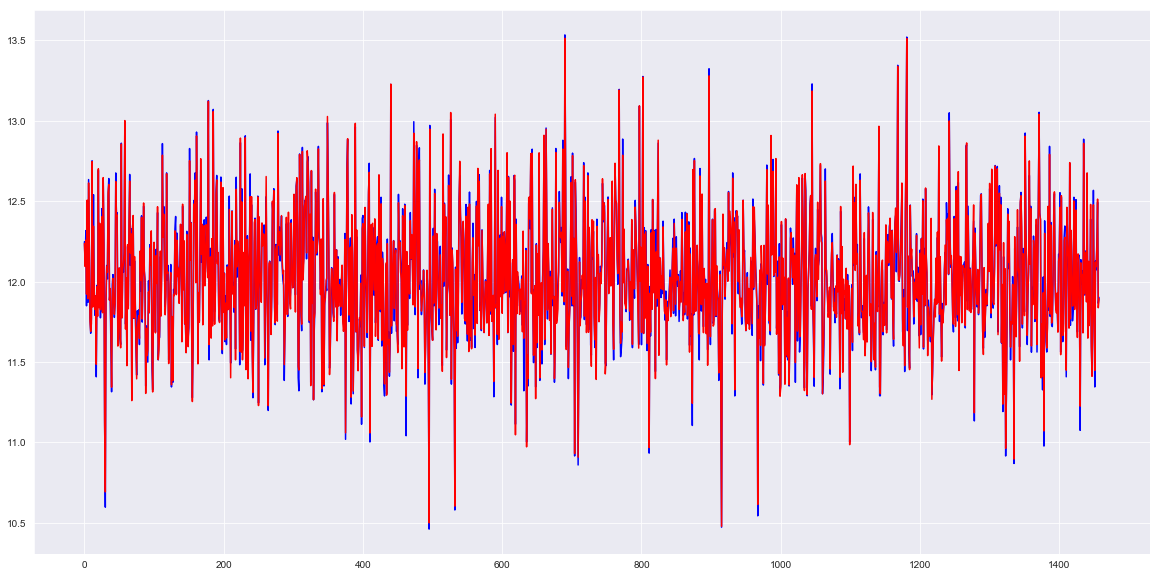

In [81]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier
from sklearn import metrics

#ml_dict = {'ml': SVR(kernel='rbf',C=1,gamma=0.01)}
#ml_dict = {'ml': RandomForestRegressor(n_estimators=300,
#                                       criterion='mse', 
#                                       max_depth=10, 
#                                       max_features='auto', 
#                                       min_samples_leaf=1, 
#                                       min_samples_split=2)}

ml_dict = {'ml': GradientBoostingRegressor(n_estimators=400,
                                           criterion='friedman_mse',  
                                           loss='ls',
                                           learning_rate=0.1,
                                           max_depth=3, 
                                           max_features=None, 
                                           min_samples_leaf=1, 
                                           min_samples_split=2)}



kf = KFold(n_splits=5, shuffle=True, random_state=123)
rms_kfold = []
for train_index, validation_index in kf.split(X):
    # X is pandas type
    X_train, X_validation =  X.iloc[train_index],  X.iloc[validation_index]
    # y is ndarray type
    y_train, y_validation = y[train_index], y[validation_index]
    model = ml_dict['ml']
    model.fit(X_train,y_train)
    prediction = model.predict(X_validation)
    prediction_exp = [np.exp(i) for i in prediction]
    y_exp = [np.exp(i) for i in y_validation]
    rms_kfold.append(np.sqrt(metrics.mean_squared_error(y_pred=prediction_exp,y_true=y_exp)))

print("mean; " + str(np.mean(rms_kfold)))
print("std; " + str(np.std(rms_kfold)))

model = ml_dict['ml']
model.fit(X,y)
draw_prediction=model.predict(X)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
drawx = np.arange(len(y))
plt.plot(drawx,y,c='b')
plt.plot(drawx,draw_prediction,c='r')
plt.show()

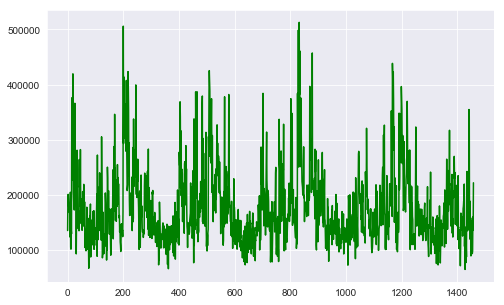

In [69]:

X2 = test.iloc[:,:]
#prediction = best_ml_pipe.predict(X2)
#ml_pipe = Pipeline([('dataProcess',dataProcess()), ('ridge', Ridge(alpha=10))])
#ml_pipe.fit(X,y)
#ml_dict = {'ml': SVR(kernel='rbf',C=1,gamma=0.01)}
model = ml_dict['ml']
model.fit(X,y)
prediction = model.predict(X2)
prediction_exp = [np.exp(i) for i in prediction]
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,5))

x = np.arange(len(X2))
plt.plot(x,prediction_exp,c='g')
plt.show()
# Output Result
result_pd = pd.DataFrame(prediction_exp,columns=['SalePrice'])
result_pd.index += 1461
result_pd.head()
result_pd.to_csv('result.csv',index=True, index_label='Id')

In [80]:
from sklearn.pipeline import Pipeline
import sklearn.metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#ml_dict = {'ml': SVR(kernel='rbf',C=1,gamma=0.01)}
#param_grid = {
#    'ml__C': [0.01,0.1,1,10,100,1000],
#    'ml__gamma': [0.01,0.1,1,10,100,1000],
#}
#--------------------------------------------------------
#ml_dict = {'ml': RandomForestRegressor(n_estimators=500,
#                                       criterion='mse', 
#                                       max_depth=10, 
#                                       max_features='auto', 
#                                       min_samples_leaf=1, 
#                                       min_samples_split=2)}
#param_grid = {
#    'ml__max_depth': [1,2,3,4,5,6,7,8,9,10],
#    'ml__n_estimators': [100,200,300,400,500],
#}
#---------------------------------------------------------
ml_dict = {'ml': GradientBoostingRegressor(n_estimators=400,
                                           criterion='friedman_mse',  
                                           loss='ls',
                                           learning_rate=0.1,
                                           max_depth=3, 
                                           max_features=None, 
                                           min_samples_leaf=1, 
                                           min_samples_split=2)}
param_grid = {
    'ml__max_depth': [1,2,3,4,5,6,7,8,9,10],
    'ml__n_estimators': [100,200,300,400,500],
}

#ml_pipe = Pipeline([('dataProcess',dataProcess()), ('SVC',  SVC())])
ml_pipe = Pipeline([('ml',ml_dict['ml'])])
kf = KFold(n_splits=3, shuffle=True, random_state=123)
# estimator need provide a score function
gsearch = GridSearchCV(estimator=ml_pipe, param_grid=param_grid, cv=kf,iid=False, n_jobs=1)
gsearch.fit(X, y)

gsearch.best_params_, gsearch.best_score_


({'ml__max_depth': 3, 'ml__n_estimators': 400}, 0.9067855767238419)

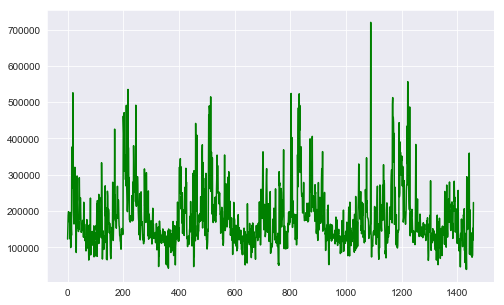

In [82]:

#ml_dict = {'ml': SVR(kernel='rbf',C=1,gamma=0.01)}
model = ml_dict['ml']
model.fit(X,y)
prediction = model.predict(X2)
prediction_exp = [np.exp(i) for i in prediction]
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,5))

x = np.arange(len(X2))
plt.plot(x,prediction_exp,c='g')
plt.show()
# Output Result
result_pd = pd.DataFrame(prediction_exp,columns=['SalePrice'])
result_pd.index += 1461
result_pd.head()
result_pd.to_csv('result.csv',index=True, index_label='Id')

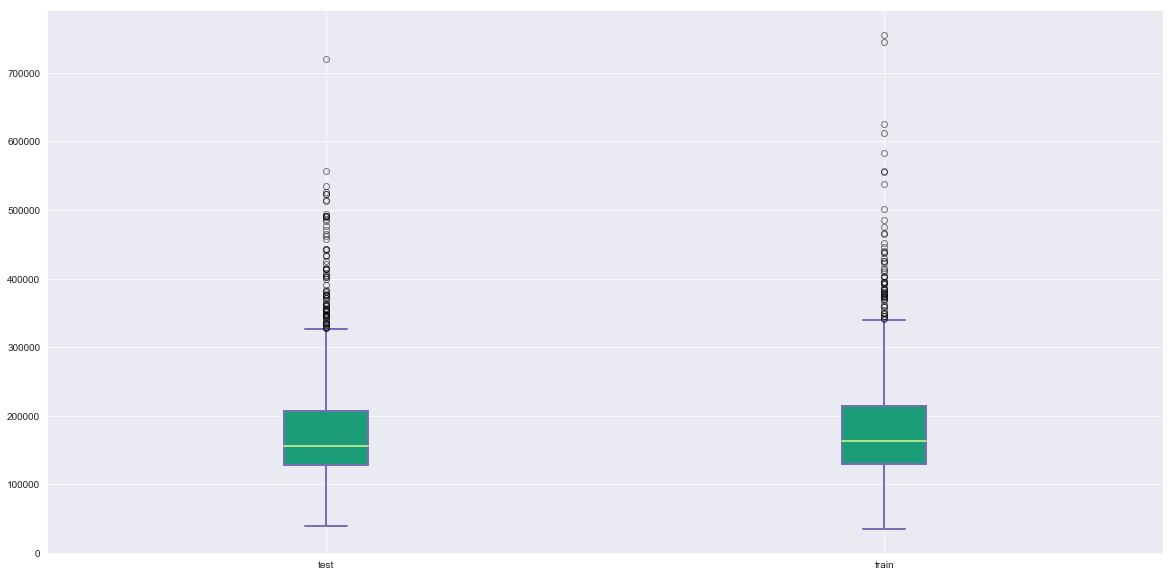

In [83]:
y_exp = [np.exp(i) for i in y]
plt.figure(figsize=(20,10))
bp = plt.boxplot([prediction_exp,y_exp],patch_artist=True,  labels=('test','train'))
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )
# 垂直線部分
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)
# Q3,Q1上下四分位數    
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## 畫出中位數
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)   
## change the style of fliers and their fill
# outlier 離群值
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

plt.show()